In [1]:
import csv
import cv2 as cv

import numpy as np
import pandas as pd
import os

from glob import glob
import matplotlib.pyplot as plt
from keras import backend as K

from keras.applications import inception_v3, inception_resnet_v2, mobilenet, resnet50, vgg16
from keras.layers import dot, Dense, GlobalAveragePooling2D, Lambda, Input
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import RMSprop, SGD

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import test image csv information

Test folder: /storage/data/humpback-whale-challenge/test
# of test images: 15610


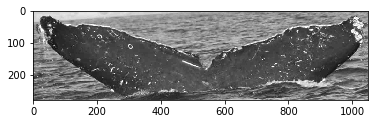

In [2]:
data_dir = '/storage/data/humpback-whale-challenge'
test_dir = 'test'

test_dict = dict()

print("Test folder: %s" %(os.path.join(data_dir,test_dir)))

for i, fn in enumerate(glob(os.path.join(data_dir,test_dir,'*.jpg'))):
    # print(fn)
    test_dict[i] = fn

img = cv.imread(os.path.join(data_dir,test_dir,"326b70e9.jpg"))
img = np.array(img,dtype=np.float32)/255
# print(img)
plt.imshow(img,)

print("# of test images: %s" %str(len(test_dict)))

## Import whale database information from training set

In [3]:
train_csv = 'train.csv'
train_dir = 'train'
df = pd.read_csv(filepath_or_buffer=os.path.join(data_dir,train_csv))

train_classes = df.groupby("Id").size()
print("\n# of unique database classes: %d" %train_classes.shape[0])

# create dictionary mapping labels to image filenames
db_img_filenames = df["Image"].tolist()
db_labels = df["Id"].tolist()
db = dict(zip(db_labels,db_img_filenames))

# remove new_whale key from dictionary
'''for i,key in enumerate(db.keys()):
    if key == "new_whale":
        print("New whale_idx: %d" %i)'''

del db["new_whale"]

# print(len(db))

# create dictionary mapping label index to label
labels_dict = {}
for i, label in enumerate(db.keys()):
    labels_dict[i]=label

# print(str(len(labels_dict)))


# of unique database classes: 4251


## Define Siamese Network

In [4]:
img_shape = (224,224,3)
weights_dir = 'weights'
weights_filename = 'crop_wts2.h5'
base_id = 4  # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3= ResNet50, 4=VGG16
enable_saved_wts = True

# choose pre-trained base network that generates a (n,1) feature vector for an input image
def create_pre_trained_base(input_shape, base_id, num_train_layers):
    # Inception-v3
    if base_id is 0:
        base = inception_v3.InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'Inception-V3'

    # MobileNet
    elif base_id is 1:
        base = mobilenet.MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'MobileNet'

    # Inception-ResNet-v2
    elif base_id is 2:
        base = inception_resnet_v2.InceptionResNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'InceptionResNet-v2'

    # ResNet50
    elif base_id is 3:
        base = resnet50.ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'ResNet50'

    # VGG16
    elif base_id is 4:
        base = vgg16.VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'VGG16'

    print("\nBase Network: %s" % base_name)

    top = GlobalAveragePooling2D()(base.output)

    # freeze all layers in the base network
    for layer in base.layers[0:len(base.layers) - num_train_layers]:
        layer.trainable = False

    model = Model(inputs=base.input, outputs=top, name='base_model')

    return model

# calculate cosine distance b/t feature vector outputs from base network
def cos_distance(feat_vects):

    K.set_epsilon(1e-07)
    epsilon = K.epsilon()

    x1, x2 = feat_vects

    result = K.maximum(x=dot(inputs=[x1, x2], axes=1, normalize=True), y=epsilon)

    return result

# create a siamese model that calculates similarity b/t two feature vectors
def create_siamese_model(base, input_shape):
    input_a = Input(shape=input_shape, name='input_a')
    input_b = Input(shape=input_shape, name='input_b')

    encoding_a = base(input_a)
    encoding_b = base(input_b)

    fc1_a = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc1_a')(encoding_a)
    fc1_b = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc1_b')(encoding_b)

    distance = Lambda(function=cos_distance, name='cos_distance', )([fc1_a, fc1_b])

    prediction = Dense(units=1, activation='sigmoid', kernel_regularizer=l2(l=0.0000), name='sigmoid')(distance)

    model = Model(inputs=[input_a, input_b], outputs=prediction, name='siamese_model')

    if enable_saved_wts is True:
        model.load_weights(filepath=weights_filename,by_name=True)
        print("Loaded weights: %s" %weights_filename)
        
    return model


# create siamese model
base_model = create_pre_trained_base(input_shape=img_shape, base_id=base_id, num_train_layers=3)
# print(base_model.summary())
siamese_model = create_siamese_model(base_model, img_shape)
print(siamese_model.summary())

# compile model
siamese_model.compile(optimizer=RMSprop(),loss="binary_crossentropy")



Base Network: VGG16
Loaded weights: crop_wts2.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
base_model (Model)              (None, 512)          14714688    input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
fc1_a (Dense)                   (None, 2048)         105062

## Test Evaluation

In [5]:
# load image from disk
def load_img(fn):

    # print(os.path.join(data_dir,fn))

    img = cv.imread(filename=os.path.join(fn),flags=0)
    img = cv.resize(src=img, dsize=(224,224), dst=img)
    img = np.array(img, dtype=np.float32)
    img /=  255
    img = np.stack((img,img,img),axis=-1)

    return img

def create_db_array(test_img):
    
    db_arr = []
    
    # temp = load_img(test_dict[0])
    
    for db_fn in db.values():
        db_img = load_img(os.path.join(data_dir,train_dir,db_fn))
        db_arr.append([db_img,test_img])
    
    db_arr = np.array(db_arr, dtype=np.float32)
    
    # print(db_arr.shape)
        
    return db_arr



In [6]:
# return top-N database predictions
def find_topN(predictions, N):

    # find N indices with the highest similarity predictions
    idxs_topN = np.argsort(predictions)[-N:]

    labels = []

    # check if maximum prediction is <= 0.5. If so, assign "new_whale" class to top-1 prediction
    idx_max = idxs_topN[N-1]
    if predictions[idx_max] <= 0.5:
        labels.append("new_whale")
        stop_idx = 0
    else:
        # labels.append(labels_dict[idx_max])
        stop_idx = -1

    for i in range(N-1,stop_idx,-1):
        idx = int(idxs_topN[i])
        labels.append(labels_dict[idx])

    return labels

n_test = len(test_dict)
n_db = len(db)
results = np.zeros(shape=(n_test,n_db),dtype=np.float32)
final_predictions = []

# iterate through all test image and db combinations
for i, test_img_fn in enumerate(test_dict.values()):

    if i > 0:
        break
        
    # import a single test image
    test_img = load_img(test_img_fn)
    offset = len(test_dir)+len(data_dir)+2

    # calculate similarity b/t test image and all db images
    # for j, query_fn in enumerate(db.values()): #[0:5]):
        
        #if j > 10: 
            #break
        # print(query_fn)
        # db_img = load_img(os.path.join(data_dir,train_dir,query_fn))
        # eval_pair = [[test_img,db_img]]
        # eval_pair = np.array(eval_pair)
        # print(eval_pair.shape)
    eval_pair = create_db_array(test_img)
    print(eval_pair.shape)
    prediction = siamese_model.predict(x=[eval_pair[:,0],eval_pair[:,1]], batch_size=16, verbose=1)
        # prediction = siamese_model.predict(x=[test_img,db_img], batch_size=1, verbose=1)
    print(prediction.shape)
    results[i] = np.transpose(prediction[0])

    topN = find_topN(results[i],5)
    final_predictions.append([test_img_fn[offset:],topN])

    print("\nImage %d: %s" %(i,test_img_fn[offset:]))
    print("Top N Predictions: %s" %str(topN))

# print(str(results))

(4250, 2, 224, 224, 3)
4250/4250 [==============================] - 81s 19ms/step
(4250, 1)

Image 0: 1a5c10f5.jpg
Top N Predictions: ['w_b9bfd4e', 'w_8cd6d46', 'w_0d8fb3f', 'w_a232f9e', 'w_6b03eb4']


## Save top-5 predictions to csv

In [7]:
# save_dir = 'results'

csv_fn = 'results.csv'

# with open(os.path.join(save_dir,csv_fn), 'w') as f:
with open(csv_fn, 'w') as f:
    writer = csv.writer(f, delimiter=',')

    for name, labels in final_predictions:
        l_concat = " ".join(labels)
        print(l_concat)
        writer.writerow([name,l_concat])

w_b9bfd4e w_8cd6d46 w_0d8fb3f w_a232f9e w_6b03eb4
